---
title: Fashion MNIST
categories: deep-learning
date: 2020-12-15
---
由于[MNIST](http://yann.lecun.com/exdb/mnist/)数据集比较简单，出现了很多替代者， [Fashion MNIST](https://eipi10.cn/others/2020/10/22/dataset#fashion-mnist)就是其中之一。 它是由Zalando（一家德国的时尚科技公司）旗下的研究部门提供，它其涵盖了来自10种类别的共7万个不同商品的正面图。本文使用Tensorflow对这个数据集进行分类，将会尝试多个模型，从简单的到复杂的，直至接近甚至达到State-of-the-Art。

![img](images/fashion-mnist-sprite.png)

目前Fashion MNIST数据集State-of-the-Art的排名如下，详见[Image Classification on Fashion-MNIST](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)。

![image-20201215144047485](images/image-20201215144047485.png)

从时间轴上看，2017年取得了96.35%的准确率。

![image-20201215144200613](images/image-20201215144200613.png)

## 初始化

首先引入所用的包。

In [49]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from IPython.display import display, Image
from sklearn.metrics import confusion_matrix
from pprint import pprint
from tensorflow.keras import datasets, models, Model, layers, callbacks, losses, optimizers, preprocessing, regularizers

# 设置日志
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

# 设置GPU内存使用上限
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
)

# 保存模型的loss, accuracy等指标
models = {}

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


然后是一些公共函数。下面代码比较长，可以先把函数的中文解释看过就好，细节忽略，后面用到再回来看。

In [2]:
class TaskTime:
    '''用于显示执行时间'''
    
    def __init__(self, task_name, show_start=False):
        self.show_start = show_start
        self.task_name = task_name
        self.start_time = time.time()

    def elapsed_time(self):
        return time.time()-self.start_time

    def __enter__(self):
        if self.show_start:
            logging.info('start {}'.format(self.task_name))
        return self;

    def __exit__(self, exc_type, exc_value, exc_tb):
        time.sleep(0.5)
        logging.info('finish {} [elapsed time: {:.2f} seconds]'.format(self.task_name, self.elapsed_time()))
        
def get_weight_num(model):
    '''得到模型可训练参数的个数'''
    return np.sum([np.prod(p.shape) for p in model.trainable_weights])

def show_images(images, labels, x_num=6, y_num=6, figsize=(8,8), classes=None):
    '''显示图片'''
    plt.figure(figsize=figsize)
    channel_count = images.shape[-1]
    for i in range(x_num*y_num):
        plt.subplot(x_num, y_num, i+1)
        if channel_count==1:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        label = labels[i] if classes is None else classes[labels[i]]
        plt.title("{}".format(label))
        plt.xticks([])
        plt.yticks([])    

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)      
    plt.show()
    
def plot_distribution(train_labels, test_labels, classes=None):
    '''打印类的分布'''
    def plot_dist(labels, title, color='blue', width = 0.7):
        bin_count = np.bincount(labels)
        bin_percentage = bin_count/len(labels)
        rects = plt.bar(np.arange(len(bin_count)), bin_count, width, color=color)
        plt.title(title)
        if classes is None:
            plt.xticks(range(len(bin_count))) 
        else:
            plt.xticks(range(len(bin_count)), labels=classes, rotation = 45) 
        plt.ylim(0, max(bin_count)*1.1) 
        
        for i, r in enumerate(rects):
            plt.annotate('{:0.1f}%'.format(int(bin_percentage[i]*100)),
                        xy=(r.get_x() + r.get_width() / 2, r.get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')        
            
    plt.figure(figsize=(16, 4))
    plt.subplot(121)
    plot_dist(train_labels, 'Train', color='teal')
    plt.subplot(122)
    plot_dist(test_labels, 'Test', color='coral')

    plt.show()    
    
def train(model, epochs, verbose=True):    
    '''要求模型设置name属性，用于保存模型。''' 
    checkpoint_best_only = callbacks.ModelCheckpoint(filepath=model.checkpoint_path,
                                                     monitor='val_accuracy',
                                                     save_weights_only=True, 
                                                     save_best_only=True,
                                                     verbose=False)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.0001, patience=int(epochs*0.2), verbose=verbose) 
    early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=int(epochs*0.3))  
    
    with TaskTime('training', True) as t: 
        history = model.fit(train_dataset, validation_data=val_dataset, 
                            epochs=epochs, verbose=verbose, 
                            callbacks=[checkpoint_best_only, reduce_lr, early_stopping])
        history.train_time = t.elapsed_time()
    return history  

def plot_history(history):
    '''显示训练的loss和accuracy的走势图'''
    plt.figure(figsize=(16, 5))
    epochs = range(1, len(history.history['accuracy'])+1)
    plt.subplot(121)
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Training', 'Validation'], loc='lower right')

    plt.subplot(122)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()    
    
def show_models(models):     
    '''按照test_accuracy倒序显示所有模型的信息'''
    models_remove1 = {key:{key1:value1 for key1, value1 in value.items() if key1 != 'model'}  for key, value in models.items()}
    df_models = pd.DataFrame.from_dict(models_remove1, orient='index')
    df_models = df_models.sort_values('test_accuracy', ascending=False) 
    display(df_models)
       
def evaluate_show(model, train_time, 
                  train_dataset, 
                  val_dataset, 
                  test_dataset, 
                  models):
    '''评估当前模型，并且显示所有模型的信息'''
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=False)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=False)
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=False)
    if  model.name not in models or models[model.name]['test_accuracy']<test_accuracy:
        models[model.name] = {'train_loss':round(train_loss, 6), 
                              'train_accuracy':round(train_accuracy, 4), 
                              'val_loss':round(val_loss, 6), 
                              'val_accuracy':round(val_accuracy, 4),    
                              'test_loss':round(test_loss, 6), 
                              'test_accuracy':round(test_accuracy, 4),                               
                              'weight_number':get_weight_num(model), 
                              'model':model,
                              'train_time':round(train_time,0)
                             }    
    show_models(models)    
    
def plot_confusion_matrix(model1, images, labels, model2=None, classes=None):
    '''打印混淆矩阵'''
    def plot_cm(model):
        predictions = model.predict(images).argmax(axis=-1)               
        cm = confusion_matrix(labels, predictions)
        bin_count = np.bincount(labels)
        if classes is None: 
            index = range(len(bin_count))      
            columns = range(len(bin_count))  
        else:
            index = classes     
            columns = classes           
        df_cm = pd.DataFrame(cm, index=index, columns=columns)
        
        plt.title("{} - Confusion matrix".format(model.name))
        sns.heatmap(df_cm, annot=True, fmt='g',cmap='coolwarm')
        if classes is not None: plt.xticks(rotation = 45)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")

    
    if model2 is not None:
        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plot_cm(model1)
        plt.subplot(1, 2, 2)
        plot_cm(model2)         
    else:  
        plt.figure(figsize=(8, 6))
        plot_cm(model1)
    
    plt.show()    
    
def plot_predicted_sample(models, images, labels, sample_count=5, show_error=True, classes=None):    
    '''查看一些样本的分类情况'''
    def get_class(label):
        if classes is None:
            return label
        else:
            return classes[label]
    
    def plot_var(model, image, label):
        predict = np.squeeze(tf.nn.softmax(model.predict(image)).numpy())
        max_like = np.argmax(predict)
        max_like_value = predict[max_like]

        if classes is None:
            _classes = range(label_count)
            plt.text(max_like-0.5, max_like_value+0.02, 
                     '{:0.1f}%'.format(max_like_value*100), fontsize=8)            
            plt.bar(_classes, predict, width=0.9, color='steelblue', alpha=0.8) 
            plt.ylim(0, 1.2)
            plt.xticks(range(label_count), _classes, fontsize=8)          
        else:
            _classes = classes
            plt.text(max_like_value+0.02, max_like, 
                     '{:0.1f}%'.format(max_like_value*100), fontsize=8)             
            plt.barh(_classes, predict, height=0.9, color='steelblue', alpha=0.8) 
            plt.xlim(0, 1.2)
            plt.yticks(range(label_count), _classes, fontsize=8)
        plt.title('{}: {}'.format(model.name, get_class(max_like)), fontsize=10)
                  
    if show_error:
        base_predictions = models[0].predict(images).argmax(axis=-1)  
        error_indexes = base_predictions != labels
        error_images = images[error_indexes]
        error_labels = labels[error_indexes]
        sample_indexes = np.random.randint(len(error_images), size=sample_count)  
        sample_images = error_images[sample_indexes]
        sample_labels = error_labels[sample_indexes]
    else:
        sample_indexes = np.random.randint(len(labels), size=sample_count)  
        sample_images = images[sample_indexes]
        sample_labels = labels[sample_indexes]
    
    bin_count = np.bincount(labels)
    label_count = len(bin_count)
    column_count = len(models)+1 
    if classes is None:
        plt.figure(figsize=(2.2*column_count, sample_count*2.2))
    else:
        plt.figure(figsize=(2.8*column_count, sample_count*2.8))
    for i in range(sample_count):
        plt.subplot(sample_count, column_count, column_count*i+1)
        plt.imshow(np.squeeze(sample_images[i]), cmap='gray', interpolation='none')
        plt.title('actual: {}'.format(get_class(sample_labels[i])), fontsize=10)
        plt.xticks([])
        plt.yticks([])

        for j, model in enumerate(models):
            plt.subplot(sample_count, column_count, column_count*i+j+2)
            plot_var(model, sample_images[i:i+1], sample_labels[i])

    plt.subplots_adjust(wspace=0.5, hspace=0.5)         
    plt.show()    
    
def plot_model_structure(model):    
    '''打印模型的结构'''
    img = tf.keras.utils.plot_model(model, '{}.png'.format(model.name), show_shapes=True) 
    display(img)
    
def load_best_checkpoint(model):
    '''加载最佳的checkpoint'''
    model.load_weights(model.checkpoint_path)
    return model    


## 数据

MNIST数据集包含60,000张training图片和10,000张test图片，每张图片由$28\times28$ 个像素点构成，每个像素点用一个灰度值(0−255)表示。下面开始加载数据。

In [3]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

train_images = np.expand_dims(train_images, axis=-1) 
test_images = np.expand_dims(test_images, axis=-1)
train_images = train_images/255.0
test_images = test_images/255.0

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


![image-20201210224132607](images/image-20201210224132607.png)

然后创建train，validatiaon和test数据集。

In [4]:
batch_size = 32

train_val_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)) 
train_val_size = train_images.shape[0]
# reshuffle_each_iteration必须设置成False，否则train_dataset和val_dataset会有重复
train_val_dataset = train_val_dataset.shuffle(train_val_size, reshuffle_each_iteration = False)  

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size)

train_size = int(0.9*train_val_size)
train_dataset = train_val_dataset.take(train_size)
train_dataset = train_dataset.shuffle(train_size, reshuffle_each_iteration = True) 
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

val_dataset = train_val_dataset.skip(train_size)
val_dataset = val_dataset.shuffle(train_val_size-train_size, reshuffle_each_iteration = True)
val_dataset = val_dataset.batch(batch_size)

input_shape = train_dataset.element_spec[0].shape[1:]

示例图片如下：

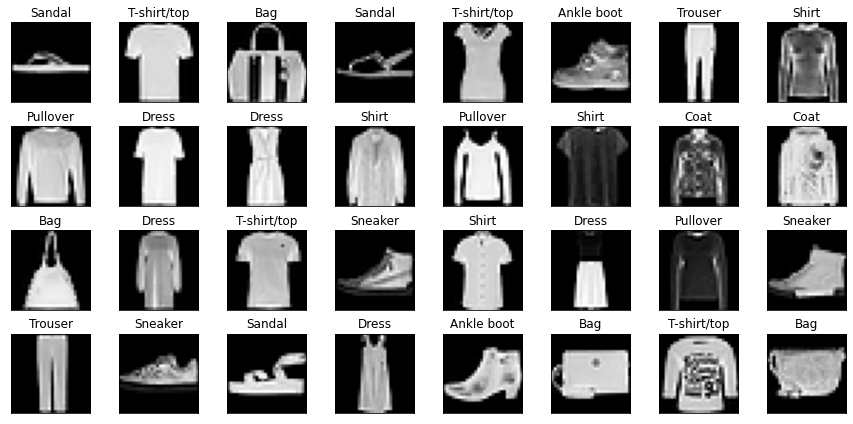

In [5]:
images, labels = iter(train_dataset).next()
show_images(images, labels, x_num=4, y_num=8, figsize=(12, 6), classes=classes)

![image-20201209150908574](images/image-20201209150908574.png)

接下来再看看数据分布。

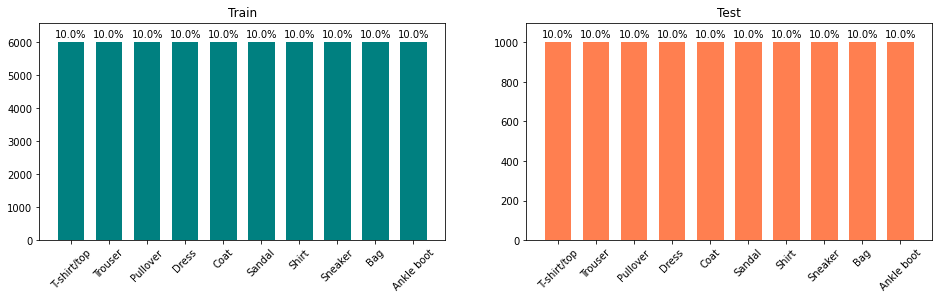

In [6]:
plot_distribution(train_labels, test_labels, classes=classes)

![image-20201211120420917](images/image-20201211120420917.png)

上图中，可以看到，数据的分布总体上是比较均匀的，而且训练数据集和测试数据集，也是几乎相同的分布。

## MLP

首先，尝试用经典的多层感知器（Muti-Layer Perception）来进行分类。下面模型是典型的三层结构，有101,770个参数。

In [7]:
def get_mlp(input_shape, learning_rate=0.001):
    input = layers.Input(shape=input_shape)
    x = layers.Flatten()(input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name='mlp') 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])  

    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model

mlp_model = get_mlp(input_shape)
mlp_model.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


![image-20201210224246538](images/image-20201210224246538.png)

下面来训练模型。

2020-12-22 01:29:37,765: INFO: start training


Epoch 1/30
1687/1687 [==============================] - 5s 3ms/step - loss: 0.5641 - accuracy: 0.7993 - val_loss: 0.3950 - val_accuracy: 0.8550
Epoch 2/30
1687/1687 [==============================] - 5s 3ms/step - loss: 0.4260 - accuracy: 0.8458 - val_loss: 0.3699 - val_accuracy: 0.8627
Epoch 3/30
1687/1687 [==============================] - 5s 3ms/step - loss: 0.3927 - accuracy: 0.8558 - val_loss: 0.3390 - val_accuracy: 0.8738
Epoch 4/30
1687/1687 [==============================] - 5s 3ms/step - loss: 0.3724 - accuracy: 0.8623 - val_loss: 0.3280 - val_accuracy: 0.8775
Epoch 5/30
1687/1687 [==============================] - 5s 3ms/step - loss: 0.3557 - accuracy: 0.8668 - val_loss: 0.3248 - val_accuracy: 0.8787
Epoch 6/30
1687/1687 [==============================] - 5s 3ms/step - loss: 0.3445 - accuracy: 0.8746 - val_loss: 0.3119 - val_accuracy: 0.8833
Epoch 7/30
1687/1687 [==============================] - 5s 3ms/step - loss: 0.3328 - accuracy: 0.8766 - val_loss: 0.3044 - val_accuracy:

2020-12-22 01:32:14,685: INFO: finish training [elapsed time: 156.92 seconds]


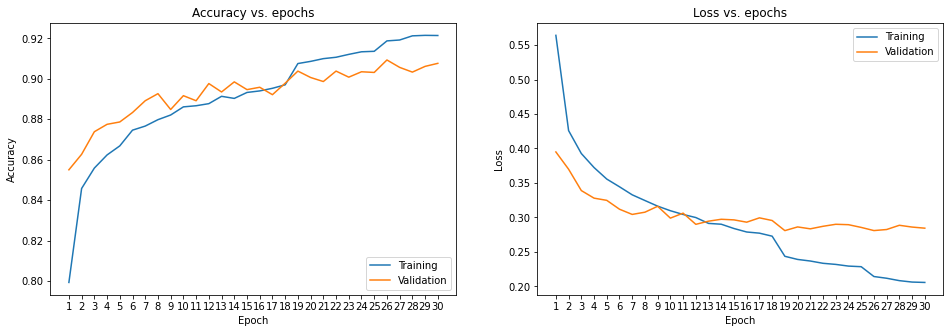

In [8]:
history = train(mlp_model, epochs=30)
plot_history(history)

![image-20201212092636482](images/image-20201212092636482.png)

![image-20201212092656908](images/image-20201212092656908.png)

可以看到对于训练数据的准确率基本趋近于100%了，这意味着模型几乎已经获得（它所能学到的）所有的模式了，再增加训练时间，也没有用了。

下面评估一下模型。

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.171389,0.9362,0.28095,0.9093,0.323632,0.8934,101770,156.0


------------------------------------------------------------------------------------------------------------------------


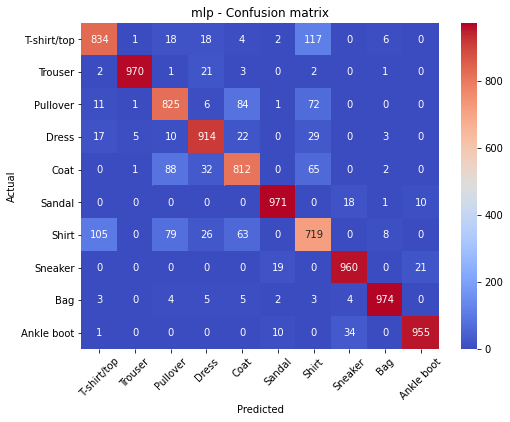

------------------------------------------------------------------------------------------------------------------------


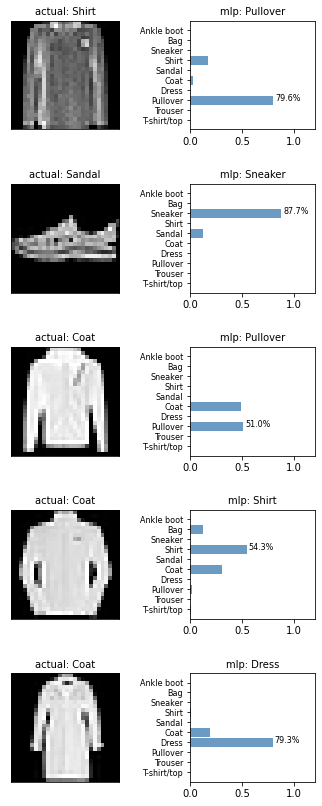

In [9]:
# 评估
mlp_model = load_best_checkpoint(get_mlp(input_shape))
evaluate_show(mlp_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(mlp_model, 
                      images=test_images, 
                      labels=test_labels,
                      classes=classes)   

# 模型对比
print('-'*120)
plot_predicted_sample([mlp_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5,
                      classes=classes
                     ) 

![image-20201212092732338](images/image-20201212092732338.png)

![image-20201212092751414](images/image-20201212092751414.png)

从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

## LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

In [10]:
def get_lenet(input_shape, learning_rate=0.001):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(6, (5, 5), activation='relu', padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(16, (5, 5), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)   
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(84, activation='relu')(x)   
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name='lenet') 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])  

    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model    

# 创建模型b
lenet_model = get_lenet(input_shape)
lenet_model.summary()

Model: "lenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64    

![image-20201211222424134](images/image-20201211222424134.png)

下面来训练模型。

2020-12-22 01:32:23,733: INFO: start training


Epoch 1/30
1687/1687 [==============================] - 8s 5ms/step - loss: 0.7115 - accuracy: 0.7421 - val_loss: 0.3814 - val_accuracy: 0.8575
Epoch 2/30
1687/1687 [==============================] - 7s 4ms/step - loss: 0.4808 - accuracy: 0.8254 - val_loss: 0.3532 - val_accuracy: 0.8608
Epoch 3/30
1687/1687 [==============================] - 8s 4ms/step - loss: 0.4317 - accuracy: 0.8448 - val_loss: 0.3237 - val_accuracy: 0.8727
Epoch 4/30
1687/1687 [==============================] - 8s 4ms/step - loss: 0.4048 - accuracy: 0.8535 - val_loss: 0.2887 - val_accuracy: 0.8907
Epoch 5/30
1687/1687 [==============================] - 7s 4ms/step - loss: 0.3890 - accuracy: 0.8599 - val_loss: 0.3014 - val_accuracy: 0.8867
Epoch 6/30
1687/1687 [==============================] - 8s 4ms/step - loss: 0.3754 - accuracy: 0.8645 - val_loss: 0.3164 - val_accuracy: 0.8793
Epoch 7/30
1687/1687 [==============================] - 7s 4ms/step - loss: 0.3646 - accuracy: 0.8668 - val_loss: 0.3018 - val_accuracy:

2020-12-22 01:36:25,224: INFO: finish training [elapsed time: 241.49 seconds]


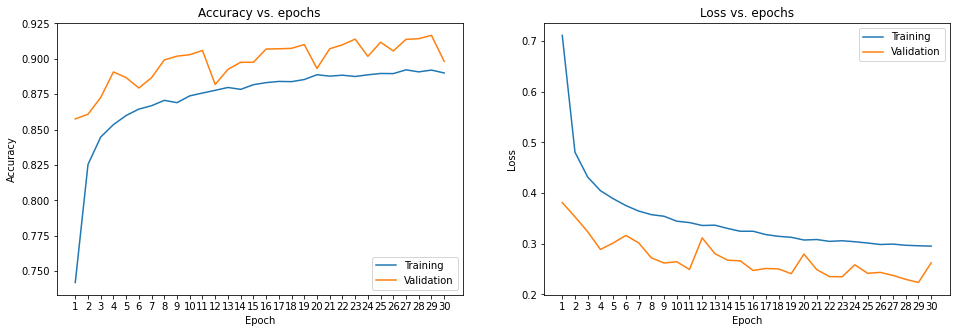

In [11]:
# 训练
history = train(lenet_model, epochs=30)
plot_history(history)

![image-20201212092848067](images/image-20201212092848067.png)

![image-20201212092907327](images/image-20201212092907327.png)

下面来评估模型并和mlp模型进行对比。

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
lenet,0.197671,0.9259,0.223573,0.9165,0.253826,0.9070,61750,241.0
mlp,0.171389,0.9362,0.280950,0.9093,0.323632,0.8934,101770,156.0


------------------------------------------------------------------------------------------------------------------------


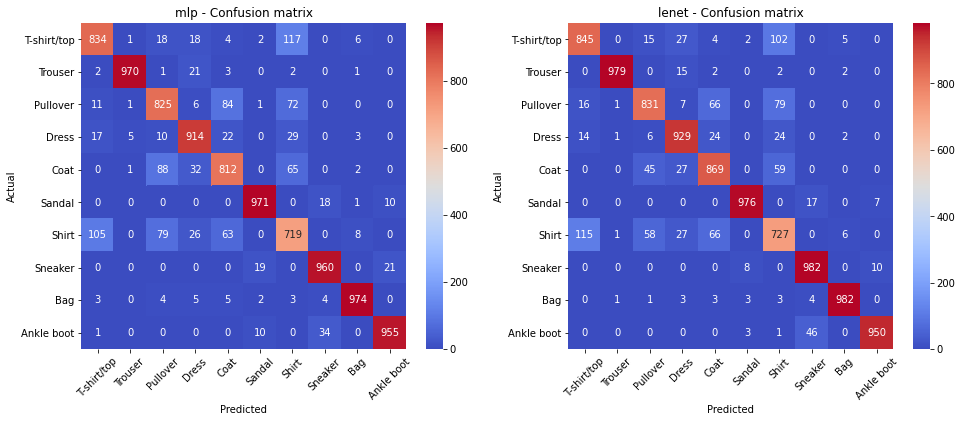

------------------------------------------------------------------------------------------------------------------------


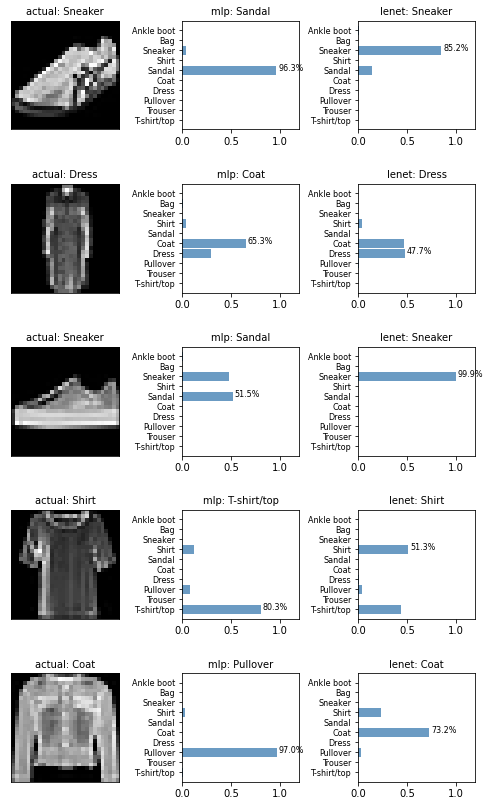

In [12]:
# 评估
lenet_model = load_best_checkpoint(get_lenet(input_shape))
evaluate_show(lenet_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(mlp_model, 
                      model2=lenet_model,
                      images=test_images, 
                      labels=test_labels,
                      classes=classes
                     )  

# 模型对比
print('-'*120)
plot_predicted_sample([mlp_model, lenet_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5,
                      classes=classes)  

![image-20201212093054193](images/image-20201212093054193.png)

![image-20201212093116228](images/image-20201212093116228.png)

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

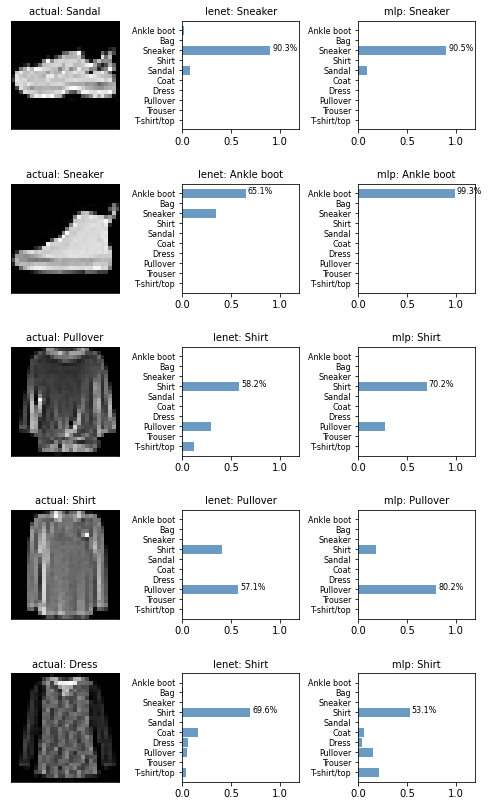

In [13]:
# 错误分析
plot_predicted_sample([lenet_model, mlp_model],
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5,
                      classes=classes) 

![image-20201212093252356](images/image-20201212093252356.png)

上图中，可以看到对于部分数字的识别，mlp甚至要更好一点啊，还有一些数字，则是一起都错了。

## Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度。

In [14]:
def get_custom1(input_shape, learning_rate=0.001):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) 
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name='custom1') 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])  
    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model   

# 创建模型
custom1_model = get_custom1(input_shape)
custom1_model.summary()

Model: "custom1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 12, 64)        256 

![image-20201212093424038](images/image-20201212093424038.png)

可以发现参数的个数已经和mlp差不多了，下面来训练模型。

2020-12-22 01:36:40,617: INFO: start training


Epoch 1/30
1687/1687 [==============================] - 8s 5ms/step - loss: 0.6827 - accuracy: 0.7529 - val_loss: 0.4082 - val_accuracy: 0.8420
Epoch 2/30
1687/1687 [==============================] - 8s 5ms/step - loss: 0.4391 - accuracy: 0.8385 - val_loss: 0.3082 - val_accuracy: 0.8822
Epoch 3/30
1687/1687 [==============================] - 8s 5ms/step - loss: 0.3773 - accuracy: 0.8616 - val_loss: 0.3709 - val_accuracy: 0.8597
Epoch 4/30
1687/1687 [==============================] - 8s 5ms/step - loss: 0.3493 - accuracy: 0.8727 - val_loss: 0.3047 - val_accuracy: 0.8870
Epoch 5/30
1687/1687 [==============================] - 8s 4ms/step - loss: 0.3308 - accuracy: 0.8801 - val_loss: 0.2635 - val_accuracy: 0.9002
Epoch 6/30
1687/1687 [==============================] - 7s 4ms/step - loss: 0.3221 - accuracy: 0.8828 - val_loss: 0.2411 - val_accuracy: 0.9127
Epoch 7/30
1687/1687 [==============================] - 7s 4ms/step - loss: 0.3050 - accuracy: 0.8884 - val_loss: 0.2638 - val_accuracy:

2020-12-22 01:40:57,064: INFO: finish training [elapsed time: 256.45 seconds]


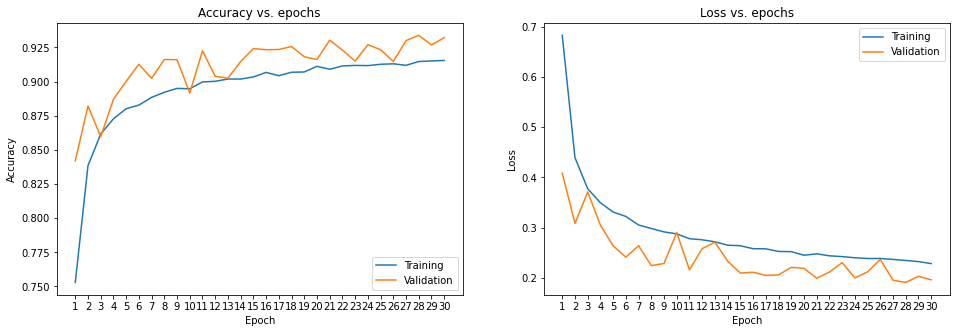

In [15]:
# 训练
history = train(custom1_model, epochs=30)
plot_history(history)

![image-20201212093601017](images/image-20201212093601017.png)

![image-20201212093643019](images/image-20201212093643019.png)

下面来评估模型并和lenet模型进行对比。

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
custom1,0.146798,0.9446,0.190638,0.9338,0.218507,0.9200,73162,256.0
lenet,0.197671,0.9259,0.223573,0.9165,0.253826,0.9070,61750,241.0
mlp,0.171389,0.9362,0.280950,0.9093,0.323632,0.8934,101770,156.0


------------------------------------------------------------------------------------------------------------------------


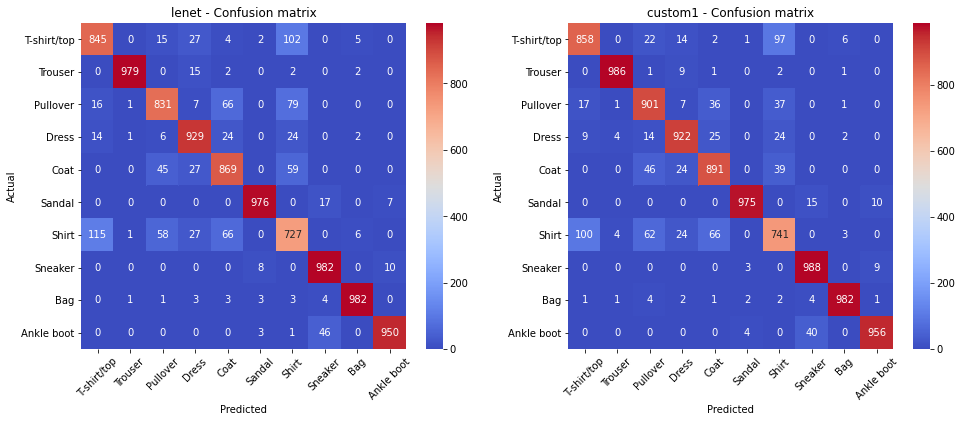

------------------------------------------------------------------------------------------------------------------------


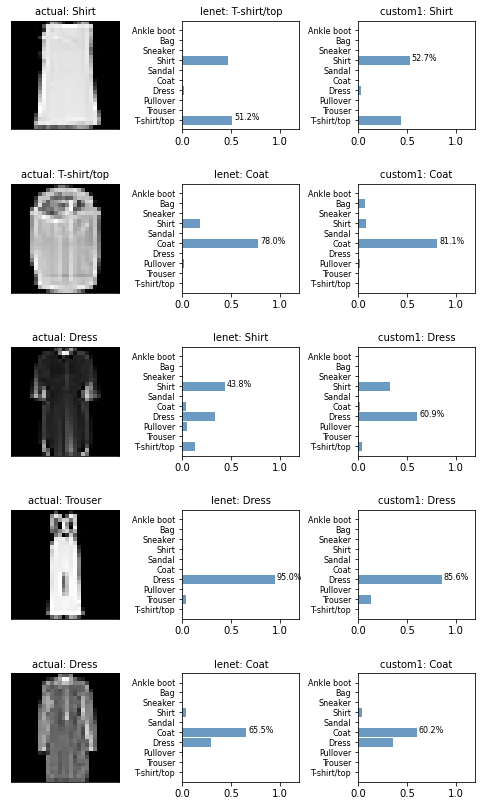

In [16]:
# 评估
custom1_model = load_best_checkpoint(get_custom1(input_shape))
evaluate_show(custom1_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(lenet_model, 
                      model2=custom1_model, 
                      images=test_images, 
                      labels=test_labels,
                      classes=classes)      

# 模型对比
print('-'*120)
plot_predicted_sample([lenet_model, custom1_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5,
                      classes=classes)   

![image-20201212093715832](images/image-20201212093715832.png)

![image-20201212093826050](images/image-20201212093826050.png)

可以看到custom1模型的效果比lenet有些许提升（经过多次测试，平均好0.1-0.3个百分点）。上面最后一幅图，也能看到custom1模型学习到了不少新的模式。下面来看错误分析。

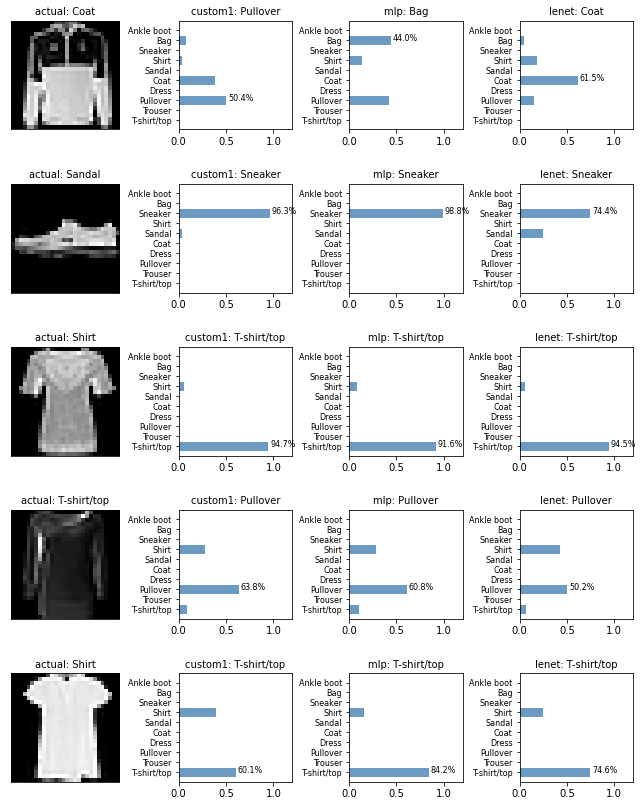

In [17]:
# 错误分析
plot_predicted_sample([custom1_model, mlp_model, lenet_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5,
                      classes=classes)    

![image-20201212094012944](images/image-20201212094012944.png)

上图中，对于有些明显的数字，custom1识别错误，看来还不尽如人意啊。

## Custom 2

下面自己定义一个模型，这个模型和custom 1比起来，进一步增加了卷积的层数，同时增加了BatchNormalization，Dropout等减少过拟合的处理。

In [18]:
def get_custom2(input_shape, learning_rate=0.001):   
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
        
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)    
    x = layers.Dense(10)(x)
    
    model = Model(inputs=input, outputs=x, name='custom2') 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])      
    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model   

# 创建模型
custom2_model = get_custom2(input_shape)
custom2_model.summary()

Model: "custom2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        1849

![image-20201212094528167](images/image-20201212094528167.png)

下面来训练模型。

2020-12-22 01:41:14,007: INFO: start training


Epoch 1/30
1687/1687 [==============================] - 10s 6ms/step - loss: 0.5907 - accuracy: 0.7850 - val_loss: 0.3229 - val_accuracy: 0.8827
Epoch 2/30
1687/1687 [==============================] - 9s 5ms/step - loss: 0.3709 - accuracy: 0.8651 - val_loss: 0.2680 - val_accuracy: 0.8975
Epoch 3/30
1687/1687 [==============================] - 17s 10ms/step - loss: 0.3282 - accuracy: 0.8824 - val_loss: 0.2543 - val_accuracy: 0.9038
Epoch 4/30
1687/1687 [==============================] - 18s 11ms/step - loss: 0.3032 - accuracy: 0.8925 - val_loss: 0.2393 - val_accuracy: 0.9113
Epoch 5/30
1687/1687 [==============================] - 18s 11ms/step - loss: 0.2807 - accuracy: 0.8990 - val_loss: 0.2327 - val_accuracy: 0.9162
Epoch 6/30
1687/1687 [==============================] - 18s 11ms/step - loss: 0.2683 - accuracy: 0.9043 - val_loss: 0.2223 - val_accuracy: 0.9203
Epoch 7/30
1687/1687 [==============================] - 18s 11ms/step - loss: 0.2552 - accuracy: 0.9083 - val_loss: 0.2208 - va

2020-12-22 01:49:18,642: INFO: finish training [elapsed time: 484.63 seconds]


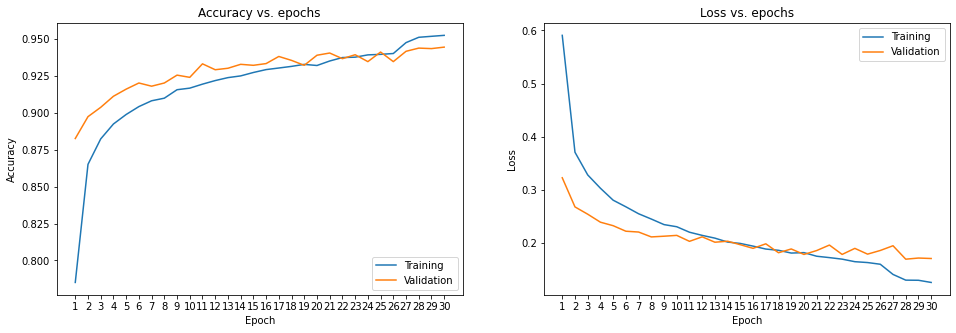

In [19]:
# 训练
history = train(custom2_model, epochs=30)
plot_history(history)

![image-20201212094804231](images/image-20201212094804231.png)

![image-20201212094816515](images/image-20201212094816515.png)

从上面的图可以看出，Validation数据集的准确率始终超过Train数据集，这证明BatchNormalization，Dropout的确减少了过拟合。

In [20]:
# history = train(custom2_model, epochs=20)

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
custom2,0.064679,0.9761,0.171005,0.9447,0.194274,0.9370,435754,484.0
custom1,0.146798,0.9446,0.190638,0.9338,0.218507,0.9200,73162,256.0
lenet,0.197671,0.9259,0.223573,0.9165,0.253826,0.9070,61750,241.0
mlp,0.171389,0.9362,0.280950,0.9093,0.323632,0.8934,101770,156.0


------------------------------------------------------------------------------------------------------------------------


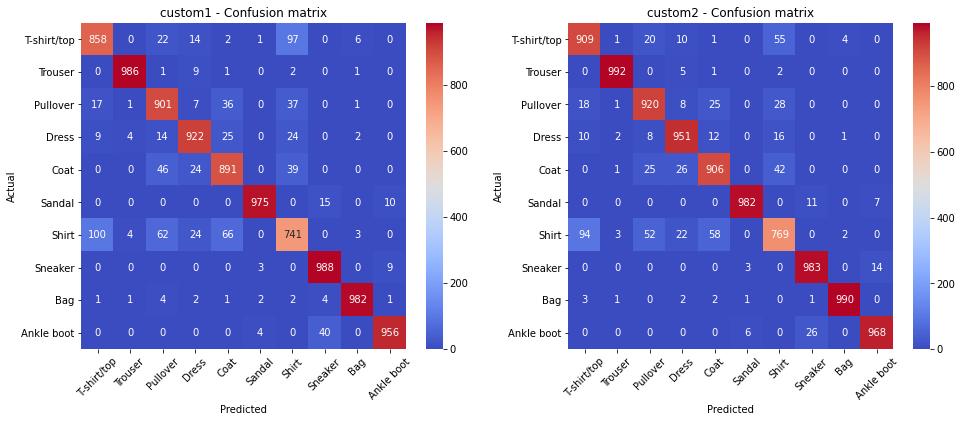

------------------------------------------------------------------------------------------------------------------------


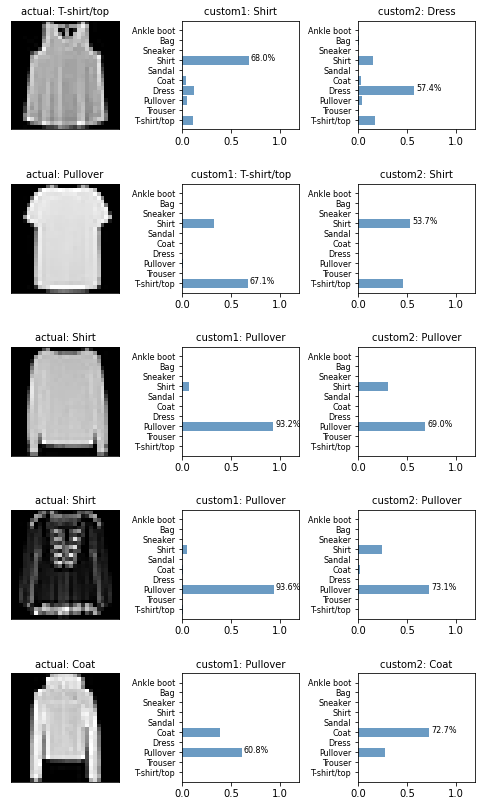

In [21]:
# 评估
custom2_model = load_best_checkpoint(get_custom2(input_shape))
evaluate_show(custom2_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(custom1_model, 
                      model2=custom2_model, 
                      images=test_images, 
                      labels=test_labels,
                      classes=classes)   

# 模型对比
print('-'*120)
plot_predicted_sample([custom1_model, custom2_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5,
                      classes=classes)   

![image-20201212095013295](images/image-20201212095013295.png)

![image-20201212095039089](images/image-20201212095039089.png)

可以看到，custom 2的模型性能有明显提高（平均比custom 1好0.2-0.4个百分点），很明显修正custom 1的一些问题。对7和2，9和4之前的区分还是难点。最后我们来看错误分析。

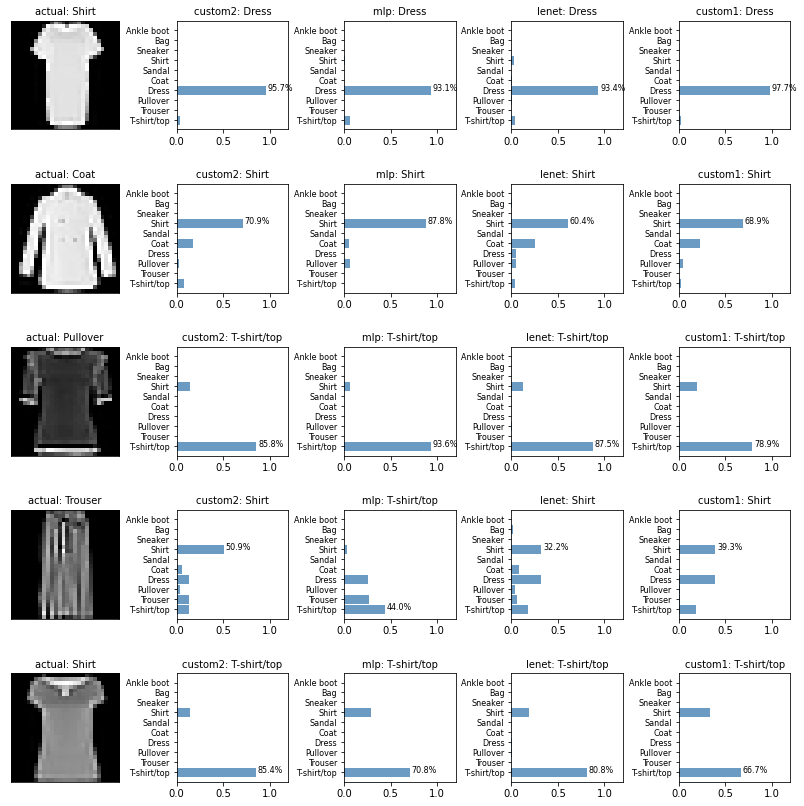

In [22]:
# 错误分析
plot_predicted_sample([custom2_model, mlp_model, lenet_model, custom1_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5,
                      classes=classes)     

![image-20201212095742132](images/image-20201212095742132.png)

## 总结

归纳上面的模型训练结果，可以得出以下几个结论。

- MNIST数据集比较简单了，很简单的算法也能轻易取得99%的准确率。

- LeNet比经典的神经网络参数要少，模型收敛更快，准确率明显提升。

- 增加卷积的深度和层数，对于准确率的提升是有明显作用的。

- 增加BatchNormalization，Dropout可以有效减少过拟合。针对custom2模型，又尝试了几种情况。

  - custom3: 在custom2基础上，移除所有BatchNormalization，Dropout
  - custom4: 在custom2基础上，移除所有BatchNormalization，留下Dropout
  - custom5: 在custom2基础上，移除所有Dropout，留下BatchNormalization

  可以得到如下统计结果，可以看到Dropout和BatchNormalization提升效果都还不错，似乎Dropout更好一点（因为train_loss相对更高，过拟合程度低一些）。由此也可以推断，如果mlp，custom1和lenet添加Dropout和BatchNormalization层，也可以提升模型的效果。

  ![image-20201212115358544](images/image-20201212115358544.png)

上面最好的模型custom 2可以取得99.61%的准确率，距离State-of-the-Art的99.84%的准确率还有不小差距。未来还会尝试data augmentation等方法，以及其它模型，以便接近甚至达到State-of-the-Art。

## 参考

- [TensorFlow 2 quickstart for beginners](https://www.tensorflow.org/tutorials/quickstart/beginner)
- [image-classification-on-mnist](https://paperswithcode.com/sota/image-classification-on-mnist)

## 历史

- 2020-10-26：初始版本。
- 2020-10-28：采用相同算法，对Fashion Mnist数据集进行分类。
- 2020-11-01：pytorch训练时，增加了validation accuaracy。
- 2020-12-12：移除了pytorch的内容，集中tensorflow本身，尝试多个模型，同时增加了分析方法。

## VGG

In [39]:
def get_block(x, filters, conv_count, kernel_size=(3, 3), padding='same', use_bn=True, 
              use_dropout=True, drop_out_rate=0.3):
    for i in range(conv_count):
        x = layers.Conv2D(filters, kernel_size, padding=padding, activation='relu')(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if use_dropout: x = layers.Dropout(drop_out_rate)(x)
    return x
    

def get_vgg9(input_shape, learning_rate=0.001, use_bn=True, use_dropout=True, drop_out_rate=0.3):   
    input = layers.Input(shape=input_shape)
    
    x = get_block(input, 64, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
    x = get_block(x, 128, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
    x = get_block(x, 256, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
#     x = get_block(x, 512, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
#     x = get_block(x, 512, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
        
    x = layers.Flatten()(x)
#     x = layers.Dense(128, activation='relu')(x)
#     if use_dropout: x = layers.Dropout(drop_out_rate)(x)  
    x = layers.Dense(128, activation='relu')(x)
    if use_dropout: x = layers.Dropout(drop_out_rate)(x)    
    x = layers.Dense(10)(x)
    
    model = Model(inputs=input, outputs=x, name='vgg9') 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])      
    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model   

# 创建模型
use_bn = True
use_dropout = True
drop_out_rate = 0.3
vgg9_model = get_vgg9(input_shape, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
vgg9_model.summary()

Model: "vgg9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_37 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_38 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 14, 14, 64)        0      

2020-12-22 11:10:45,541: INFO: start training


Epoch 1/30


2020-12-22 11:10:46,358: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 11:10:46,360: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 11:10:46,361: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 11:10:46,362: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 11:10:46,363: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 11:10:46,364: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


1687/1687 [==============================] - 18s 11ms/step - loss: 0.5310 - accuracy: 0.8109 - val_loss: 0.2943 - val_accuracy: 0.8920
Epoch 2/30
1687/1687 [==============================] - 18s 11ms/step - loss: 0.3425 - accuracy: 0.8787 - val_loss: 0.2582 - val_accuracy: 0.9080
Epoch 3/30
1687/1687 [==============================] - 18s 11ms/step - loss: 0.2988 - accuracy: 0.8945 - val_loss: 0.2805 - val_accuracy: 0.8938
Epoch 4/30
1687/1687 [==============================] - 18s 11ms/step - loss: 0.2678 - accuracy: 0.9057 - val_loss: 0.2193 - val_accuracy: 0.9182
Epoch 5/30
1687/1687 [==============================] - 18s 11ms/step - loss: 0.2488 - accuracy: 0.9115 - val_loss: 0.2580 - val_accuracy: 0.9067
Epoch 6/30
1687/1687 [==============================] - 18s 11ms/step - loss: 0.2266 - accuracy: 0.9200 - val_loss: 0.2022 - val_accuracy: 0.9290
Epoch 7/30
1687/1687 [==============================] - 18s 11ms/step - loss: 0.2085 - accuracy: 0.9242 - val_loss: 0.2278 - val_accura

2020-12-22 11:20:47,533: INFO: finish training [elapsed time: 601.99 seconds]


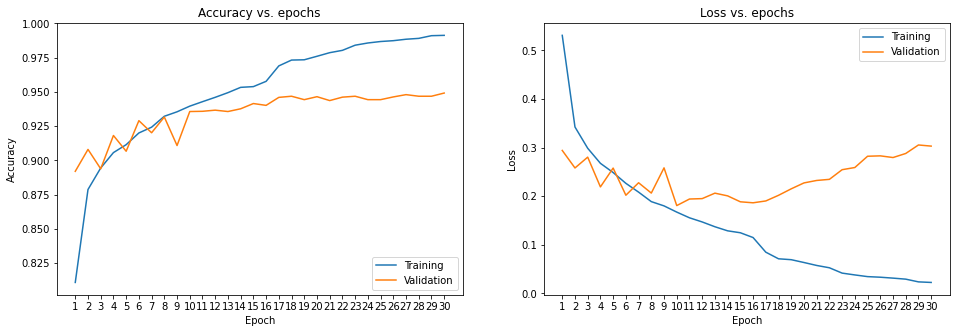

In [40]:
# 训练
history = train(vgg9_model, epochs=30)
plot_history(history)

In [25]:
# models={}
# evaluate_show(vgg9_model, 
#               train_time=history.train_time,
#               train_dataset=train_dataset, 
#               val_dataset=val_dataset, 
#               test_dataset=test_dataset, 
#               models=models
#              )
# models={}
# vgg9_model = get_vgg9(input_shape, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
# vgg9_model = load_best_checkpoint(vgg9_model)
# evaluate_show(vgg9_model, 
#               train_time=history.train_time,
#               train_dataset=train_dataset, 
#               val_dataset=val_dataset, 
#               test_dataset=test_dataset, 
#               models=models
#              )

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
vgg_hpt,0.026084,0.9923,0.189973,0.9462,0.210764,0.9427,1206826,369.0
vgg9,0.003431,0.9993,0.303195,0.9492,0.336668,0.9426,1442378,601.0
custom2,0.064679,0.9761,0.171005,0.9447,0.194274,0.9370,435754,484.0
custom1,0.146798,0.9446,0.190638,0.9338,0.218507,0.9200,73162,256.0
lenet,0.197671,0.9259,0.223573,0.9165,0.253826,0.9070,61750,241.0
mlp,0.171389,0.9362,0.280950,0.9093,0.323632,0.8934,101770,156.0


------------------------------------------------------------------------------------------------------------------------


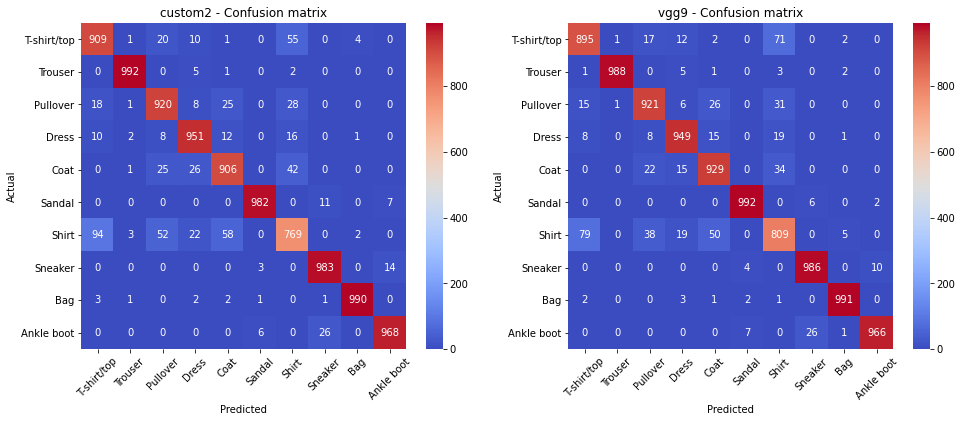

------------------------------------------------------------------------------------------------------------------------


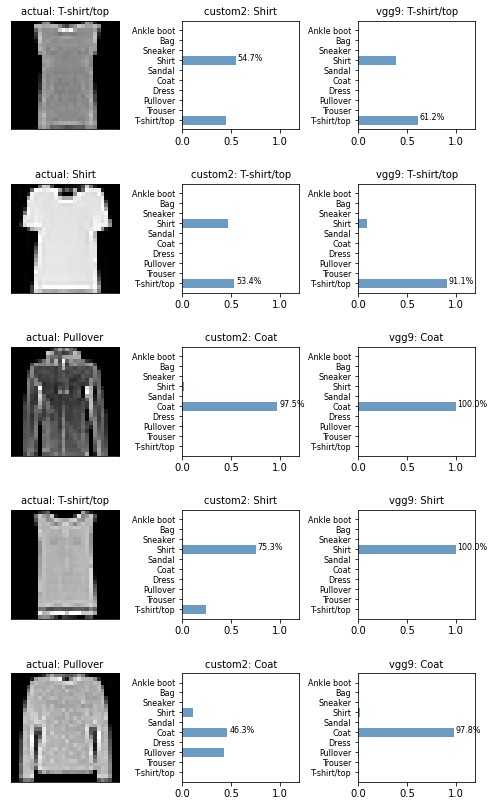

In [42]:
# 评估
vgg9_model = get_vgg9(input_shape, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
vgg9_model = load_best_checkpoint(vgg9_model)
evaluate_show(vgg9_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(custom2_model, 
                      model2=vgg9_model, 
                      images=test_images, 
                      labels=test_labels,
                      classes=classes)   

# 模型对比
print('-'*120)
plot_predicted_sample([custom2_model, vgg9_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5,
                      classes=classes)  

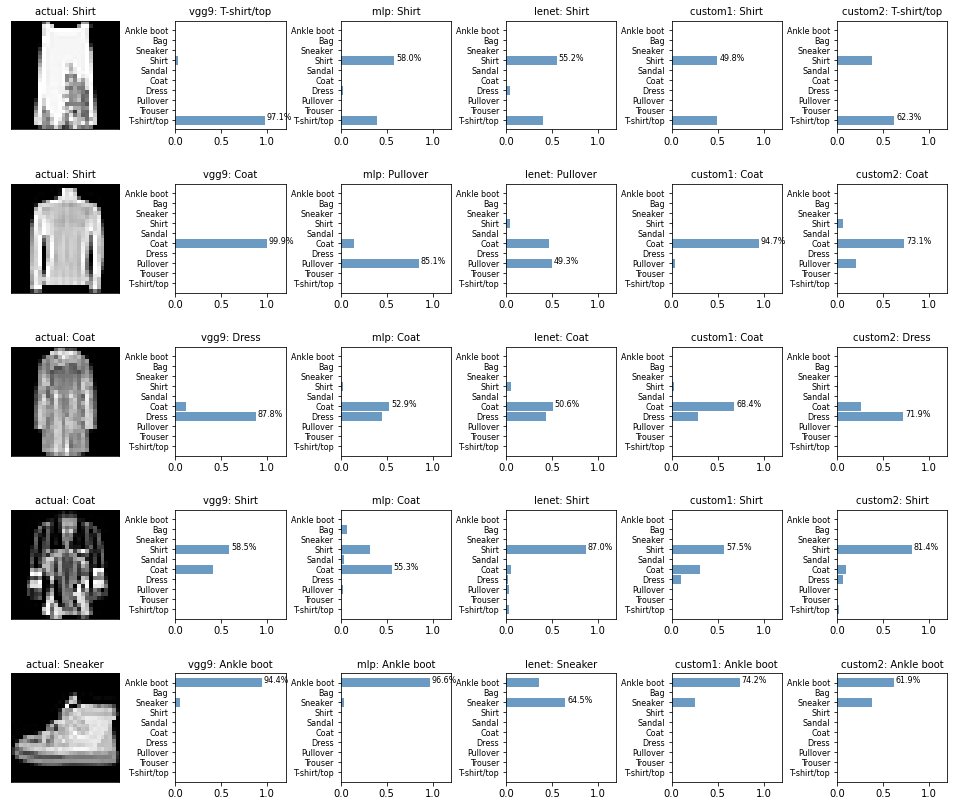

In [34]:
# 错误分析
plot_predicted_sample([vgg9_model, mlp_model, lenet_model, custom1_model, custom2_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5,
                      classes=classes)  

In [28]:
# ! tensorboard --logdir logs/vgg_hparam_tuning_full --bind_all

In [43]:
def get_block(x, filters, conv_count, kernel_size=(3, 3), padding='same', use_bn=True, 
              use_dropout=True, drop_out_rate=0.3):
    for i in range(conv_count):
        x = layers.Conv2D(filters, kernel_size, padding=padding, activation='relu')(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if use_dropout: x = layers.Dropout(drop_out_rate)(x)
    return x
    

def get_model(model_name,
              input_shape,
              dense_layer_count=1, 
              dense_layer_units=64,
              learning_rate=0.001,
              vgg_block_count=3,
              use_bn=True, 
              drop_out_rate=0):   
    input = layers.Input(shape=input_shape)
    use_dropout = drop_out_rate>0
    
    filter = 32
    x = get_block(input, filter, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
    for i in range(vgg_block_count-1):
        filter = filter*2
        x = get_block(x, filter, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
                    
    x = layers.Flatten()(x)
    for i in range(dense_layer_count):
        x = layers.Dense(128, activation='relu')(x)
        if use_dropout: x = layers.Dropout(drop_out_rate)(x)     
    x = layers.Dense(10)(x)
    
    model = Model(inputs=input, outputs=x, name=model_name) 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])      
    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model 

use_bn = True
use_dropout = True
drop_out_rate = 0.3
vgg_hpt_model = get_model('vgg_hpt',
                          input_shape,
                          dense_layer_count=1, 
                          dense_layer_units=128,
                          learning_rate=0.001,
                          vgg_block_count=4,
                          use_bn=True, 
                          drop_out_rate=0.3)
vgg_hpt_model.summary()

2020-12-22 11:21:54,830: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 11:21:54,832: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 11:21:54,833: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 11:21:54,834: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 11:21:54,835: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 11:21:54,836: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


Model: "vgg_hpt"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_49 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_50 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 14, 14, 32)        0   

2020-12-22 11:21:55,013: INFO: start training


Epoch 1/30
1687/1687 [==============================] - 22s 13ms/step - loss: 0.5889 - accuracy: 0.7911 - val_loss: 0.3480 - val_accuracy: 0.8713
Epoch 2/30
1687/1687 [==============================] - 21s 13ms/step - loss: 0.3523 - accuracy: 0.8746 - val_loss: 0.2801 - val_accuracy: 0.8950
Epoch 3/30
1687/1687 [==============================] - 18s 11ms/step - loss: 0.3082 - accuracy: 0.8907 - val_loss: 0.2725 - val_accuracy: 0.8990
Epoch 4/30
1687/1687 [==============================] - 11s 7ms/step - loss: 0.2754 - accuracy: 0.9024 - val_loss: 0.2355 - val_accuracy: 0.9100
Epoch 5/30
1687/1687 [==============================] - 11s 7ms/step - loss: 0.2551 - accuracy: 0.9100 - val_loss: 0.2309 - val_accuracy: 0.9145
Epoch 6/30
1687/1687 [==============================] - 11s 7ms/step - loss: 0.2373 - accuracy: 0.9164 - val_loss: 0.2662 - val_accuracy: 0.9028
Epoch 7/30
1687/1687 [==============================] - 14s 8ms/step - loss: 0.2222 - accuracy: 0.9203 - val_loss: 0.1986 - val

2020-12-22 11:29:53,322: INFO: finish training [elapsed time: 478.31 seconds]


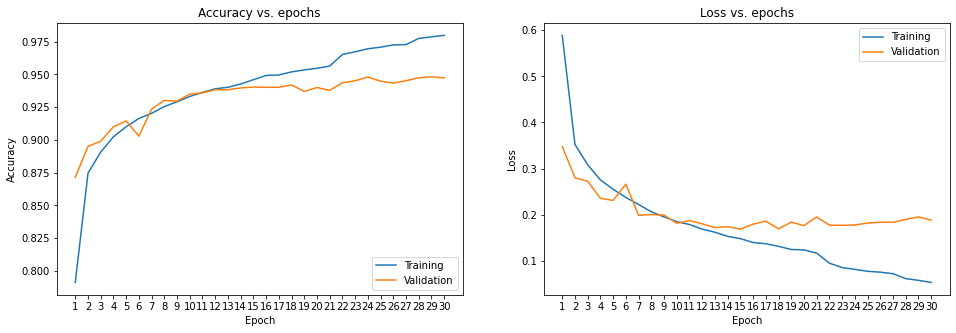

In [44]:
# 训练
history = train(vgg_hpt_model, epochs=30)
plot_history(history)

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
vgg_hpt,0.018663,0.9946,0.195092,0.9482,0.225550,0.9428,1207786,478.0
vgg9,0.003431,0.9993,0.303195,0.9492,0.336668,0.9426,1442378,601.0
custom2,0.064679,0.9761,0.171005,0.9447,0.194274,0.9370,435754,484.0
custom1,0.146798,0.9446,0.190638,0.9338,0.218507,0.9200,73162,256.0
lenet,0.197671,0.9259,0.223573,0.9165,0.253826,0.9070,61750,241.0
mlp,0.171389,0.9362,0.280950,0.9093,0.323632,0.8934,101770,156.0


------------------------------------------------------------------------------------------------------------------------


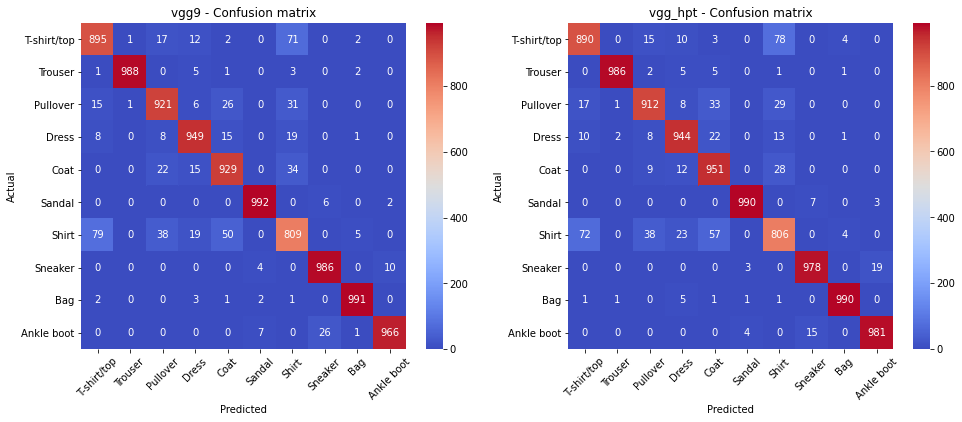

------------------------------------------------------------------------------------------------------------------------


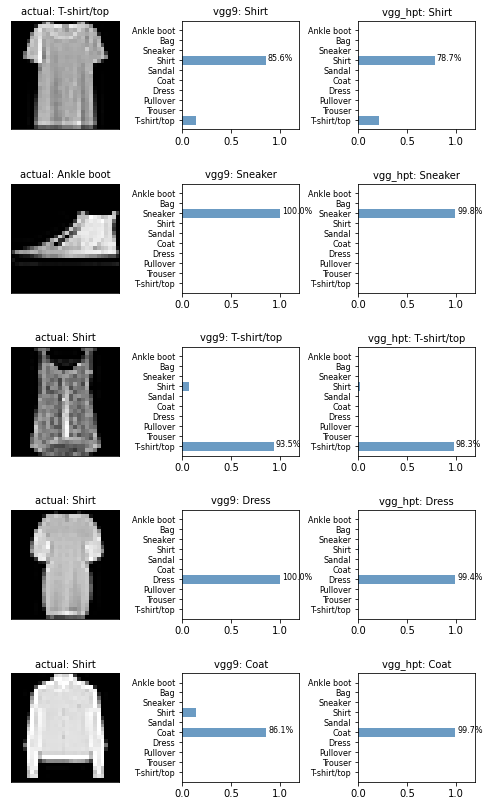

In [45]:
# 评估
vgg_hpt_model = get_model('vgg_hpt',
                          input_shape,
                          dense_layer_count=1, 
                          dense_layer_units=128,
                          learning_rate=0.001,
                          vgg_block_count=4,
                          use_bn=True, 
                          drop_out_rate=0.3)
vgg_hpt_model = load_best_checkpoint(vgg_hpt_model)
evaluate_show(vgg_hpt_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(vgg9_model, 
                      model2=vgg_hpt_model, 
                      images=test_images, 
                      labels=test_labels,
                      classes=classes)   

# 模型对比
print('-'*120)
plot_predicted_sample([vgg9_model, vgg_hpt_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5,
                      classes=classes)  

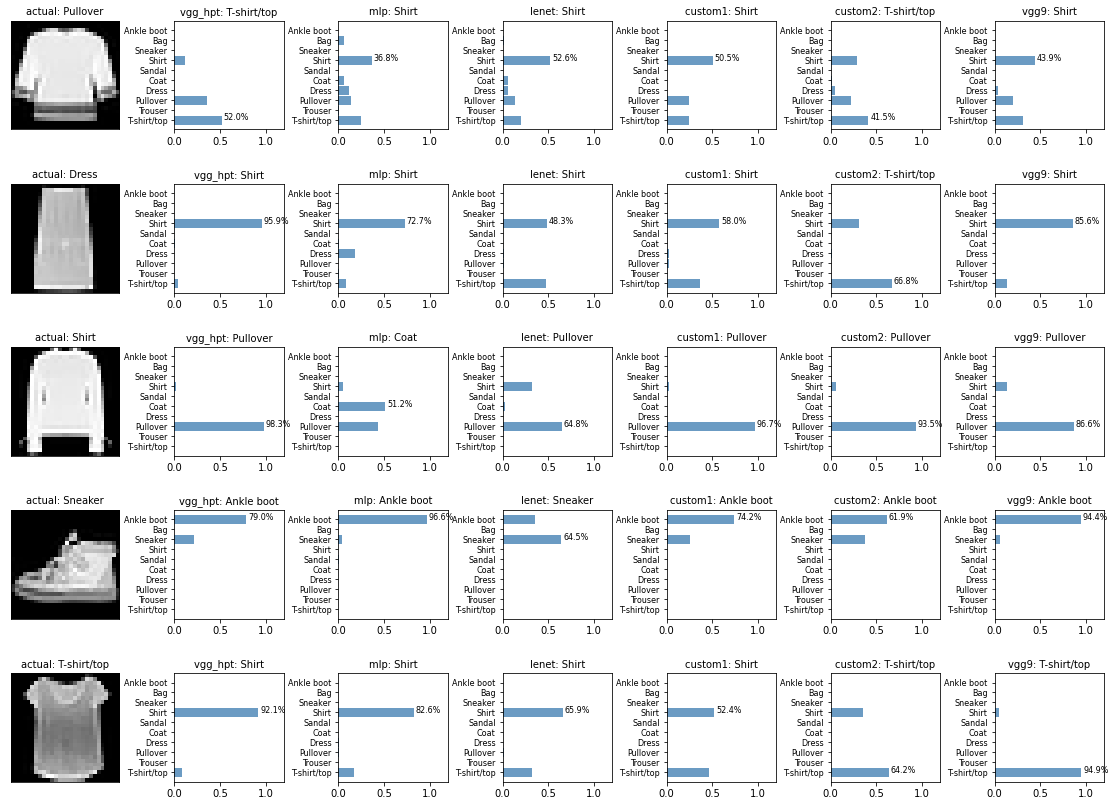

In [38]:
# 错误分析
plot_predicted_sample([vgg_hpt_model, mlp_model, lenet_model, custom1_model, custom2_model, vgg9_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5,
                      classes=classes) 

## Residual Netowork

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [73]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10, model_name='resnet_v1'):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = layers.add([x, y])
            x = layers.Activation('relu')(x)

        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = layers.AveragePooling2D(pool_size=7)(x)
    y = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

def get_resnet_v1(input_shape, depth=32, learning_rate=0.001):   
    model = resnet_v1(input_shape=input_shape, depth=depth, model_name='resnet_v1_{}'.format(depth))
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])      
    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model 

resnet_v1_model = get_resnet_v1(input_shape, depth=20, learning_rate=0.001)
resnet_v1_model.summary()

Model: "resnet_v1_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1091 (Conv2D)            (None, 28, 28, 16)   160         input_39[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1026 (Batch (None, 28, 28, 16)   64          conv2d_1091[0][0]                
__________________________________________________________________________________________________
activation_961 (Activation)     (None, 28, 28, 16)   0           batch_normalization_1026[0][0]   
_______________________________________________________________________________________

In [74]:
print(len(resnet_v1_model.layers))

72


2020-12-22 12:34:23,936: INFO: start training


Epoch 1/30
1687/1687 [==============================] - 26s 16ms/step - loss: 0.6077 - accuracy: 0.8368 - val_loss: 0.5717 - val_accuracy: 0.8428
Epoch 2/30
1687/1687 [==============================] - 26s 15ms/step - loss: 0.4340 - accuracy: 0.8916 - val_loss: 0.4199 - val_accuracy: 0.8985
Epoch 3/30
1687/1687 [==============================] - 26s 15ms/step - loss: 0.3811 - accuracy: 0.9081 - val_loss: 0.4929 - val_accuracy: 0.8597
Epoch 4/30
1687/1687 [==============================] - 26s 15ms/step - loss: 0.3511 - accuracy: 0.9163 - val_loss: 0.3765 - val_accuracy: 0.9045
Epoch 5/30
1687/1687 [==============================] - 26s 15ms/step - loss: 0.3311 - accuracy: 0.9217 - val_loss: 0.3338 - val_accuracy: 0.9207
Epoch 6/30
1687/1687 [==============================] - 25s 15ms/step - loss: 0.3158 - accuracy: 0.9268 - val_loss: 0.3639 - val_accuracy: 0.9128
Epoch 7/30
1687/1687 [==============================] - 26s 15ms/step - loss: 0.3022 - accuracy: 0.9314 - val_loss: 0.3719 -

2020-12-22 12:48:12,687: INFO: finish training [elapsed time: 828.75 seconds]


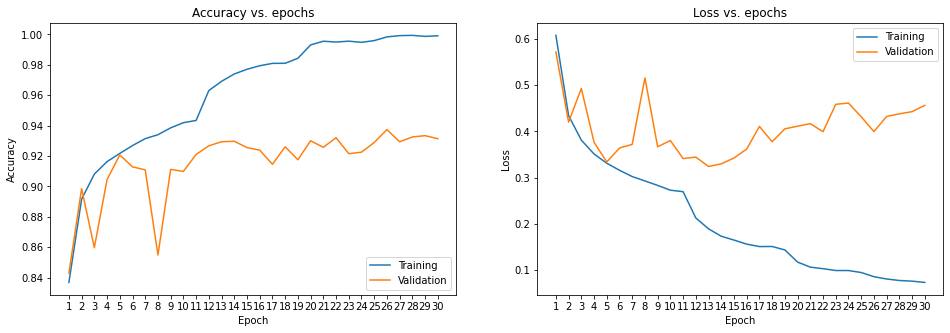

In [75]:
history = train(resnet_v1_model, epochs=30)
plot_history(history)